In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary
from build_model_logistic import build_v2g_model_binary_from_df
from get_data import init_column_map, pull_data_rowwise

In [2]:
# Define all variable categories
from variables import (
    demographics, input_variables_vehicle_ownership, familiarity, kms_driven, renewables_at_home,
    parking, q6a_cols, energ_literacy, renewables_at_home, intent_to_purchase_vehicle,
    benefits_v2g, concerns_v2g, interest_in_services, consider_using_NRMA_for,
    charging_control, preference_on_batt_use, expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

# TBD -> Make function here
columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Clean data

In [7]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 4. 0. 1.]
Unique values in Q6ax1_2: [5. 1. 3. 2. 4. 0.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5. 4. 3. 1. 2. 0.]
Unique values in Q6ax2_2: [5. 4. 3. 2. 0. 1.]
Unique values in Q6ax2_3: [5. 4. 3. 1. 0. 2.]
Unique values in Q6ax3_1: [3. 1. 4. 0. 2. 5.]
Unique values in Q6ax3_2: [5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [5. 2. 3. 0. 4. 1.]
Unique values in Q6ax4_3: [5. 3. 0. 1. 4. 2.]


In [8]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1    118
Q6ax1_2     28
Q6ax1_3     31
Q6ax2_1    102
Q6ax2_2     24
Q6ax2_3     14
Q6ax3_1      4
Q6ax3_2      0
Q6ax3_3      0
Q6ax4_1     12
Q6ax4_2      6
Q6ax4_3      9
dtype: int64


In [9]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    874
Q6ax1_2    874
Q6ax1_3    874
Q6ax2_1    768
Q6ax2_2    768
Q6ax2_3    768
Q6ax3_1     33
Q6ax3_2     33
Q6ax3_3     33
Q6ax4_1    111
Q6ax4_2    111
Q6ax4_3    111
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [10]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [11]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [12]:
print("TRANSFORMERS_q6a keys:", list(TRANSFORMERS_q6a.keys()))  # Print first 10 keys


TRANSFORMERS_q6a keys: ['Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_99', 'Q2', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q7_1', 'Q7_2', 'Q7_3', 'Q8_1', 'Q8_2', 'Q8_99', 'Q9', 'Q10_2', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_7', 'Q14_8', 'Q14_99', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q15_7', 'Q15_8', 'Q15_9', 'Q15_10', 'Q15_99', 'Q6ax1_1', 'Q6ax1_2', 'Q6ax1_3', 'Q6ax2_1', 'Q6ax2_2', 'Q6ax2_3', 'Q6ax3_1', 'Q6ax3_2', 'Q6ax3_3', 'Q6ax4_1', 'Q6ax4_2', 'Q6ax4_3']


In [13]:
def text_to_code_q10_2_binary(raw_ans):
    """
    Converts Q10_2 from 5-category responses to binary:
    - "Strongly disagree", "Somewhat disagree", "Neither agree nor disagree" → 0 (Not adopting)
    - "Somewhat agree", "Strongly agree" → 1 (Adopting)
    """
    adopting = {"Somewhat agree", "Strongly agree"}
    return 1 if raw_ans in adopting else 0

In [14]:
TRANSFORMERS_q6a["Q10_2"] = text_to_code_q10_2_binary

In [15]:
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [16]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
    energ_literacy
)

In [17]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

## 3.2. Vehicle at home habits

In [18]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1     484
Q6ax1_2     484
Q6ax1_3     484
Q6ax2_1     590
Q6ax2_2     590
Q6ax2_3     590
Q6ax3_1    1325
Q6ax3_2    1325
Q6ax3_3    1325
Q6ax4_1    1247
Q6ax4_2    1247
Q6ax4_3    1247
dtype: int64


In [19]:
df[q6a_cols] = df[q6a_cols].fillna(0)


In [20]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 1. 0. 3. 2. 4.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax2_2: [0. 5. 4. 3. 2. 1.]
Unique values in Q6ax2_3: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax3_1: [0. 3. 1. 4. 2. 5.]
Unique values in Q6ax3_2: [0. 5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [0. 5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [0. 5. 2. 3. 4. 1.]
Unique values in Q6ax4_3: [0. 5. 3. 1. 4. 2.]


In [21]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

In [22]:
# Initialize list to store results
results = []

# Loop through each feature in features_to_select
for feature in features_to_select:
    print(f"Running Logistic Regression for: {feature}")

    # Ensure the feature exists in the dataframe
    if feature not in df.columns:
        print(f"Skipping {feature} (not in dataframe)")
        continue

    # Apply appropriate filters based on the type of vehicle
    if feature in q6a_petrol:
        filtered_df = df[q6a_filters["petrol"]]
    elif feature in q6a_ev:
        filtered_df = df[q6a_filters["ev"]]
    elif feature in q6a_plughyb:
        filtered_df = df[q6a_filters["plug_hybrid"]]
    elif feature in q6a_hybrid:
        filtered_df = df[q6a_filters["hybrid"]]
    else:
        filtered_df = df  # Default (includes all data)

    # Ensure enough data is available for analysis
    if filtered_df.shape[0] < 10:  # Skip if too few respondents
        print(f"Skipping {feature} (too few valid rows: {filtered_df.shape[0]})")
        continue

    # Convert feature using transformer if available, otherwise cast to numeric
    if feature in TRANSFORMERS_q6a:
        X_single = filtered_df[feature].apply(TRANSFORMERS_q6a[feature])
    else:
        X_single = pd.to_numeric(filtered_df[feature], errors="coerce")  # Convert safely

    # Drop NaN values
    valid_rows = ~X_single.isna()

    print(f"Valid rows are {valid_rows.count()}")
    
    X_single = X_single[valid_rows].values.reshape(-1, 1)
    y = filtered_df.loc[valid_rows, target_variable].values  # Ensure target aligns with valid rows

    # Check if feature has only one unique value
    if len(np.unique(X_single)) == 1:
        print(f"Skipping {feature} (constant value: {np.unique(X_single)[0]})")
        continue

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficient & odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)

    # Fit logistic regression using statsmodels for p-value
    X_with_intercept = sm.add_constant(X_single)
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress verbose output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by strongest effect (absolute coefficient)
results_df["abs_coef"] = results_df["Coefficient"].abs()
results_df = results_df.sort_values(by="abs_coef", ascending=False)

Running Logistic Regression for: Q9
Valid rows are 1358
Running Logistic Regression for: Q2
Valid rows are 1358
Running Logistic Regression for: Q8_1
Valid rows are 1358
Running Logistic Regression for: Q8_2
Valid rows are 1358
Running Logistic Regression for: Q8_99
Valid rows are 1358
Running Logistic Regression for: Q1_1
Valid rows are 1358
Running Logistic Regression for: Q1_2
Valid rows are 1358
Running Logistic Regression for: Q1_3
Valid rows are 1358
Running Logistic Regression for: Q1_4
Valid rows are 1358
Running Logistic Regression for: Q1_99
Valid rows are 1358
Running Logistic Regression for: Q6ax1_1
Valid rows are 874
Running Logistic Regression for: Q6ax1_2
Valid rows are 874
Running Logistic Regression for: Q6ax1_3
Valid rows are 874
Running Logistic Regression for: Q6ax2_1
Valid rows are 768
Running Logistic Regression for: Q6ax2_2
Valid rows are 768
Running Logistic Regression for: Q6ax2_3
Valid rows are 768
Running Logistic Regression for: Q6ax4_1
Valid rows are 111
Ru

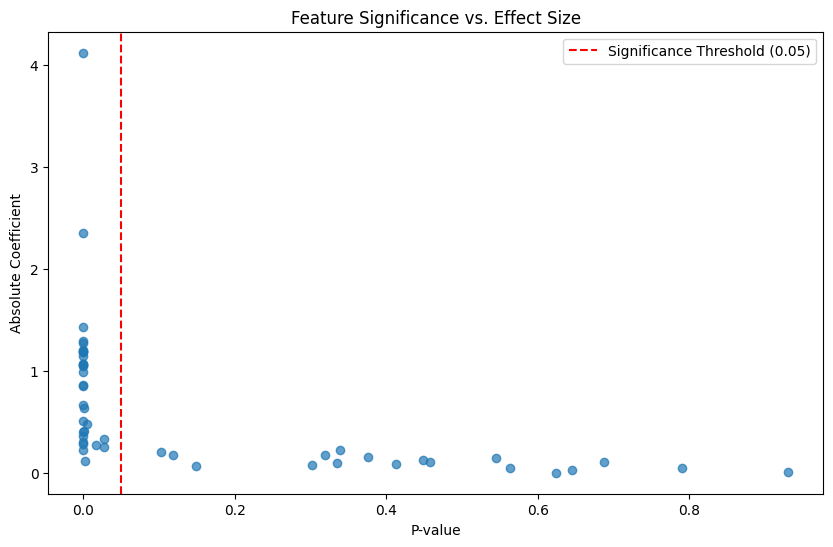

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df["P-value"], results_df["abs_coef"], alpha=0.7)
plt.axvline(x=0.05, color="red", linestyle="--", label="Significance Threshold (0.05)")
plt.xlabel("P-value")
plt.ylabel("Absolute Coefficient")
plt.title("Feature Significance vs. Effect Size")
plt.legend()
plt.show()

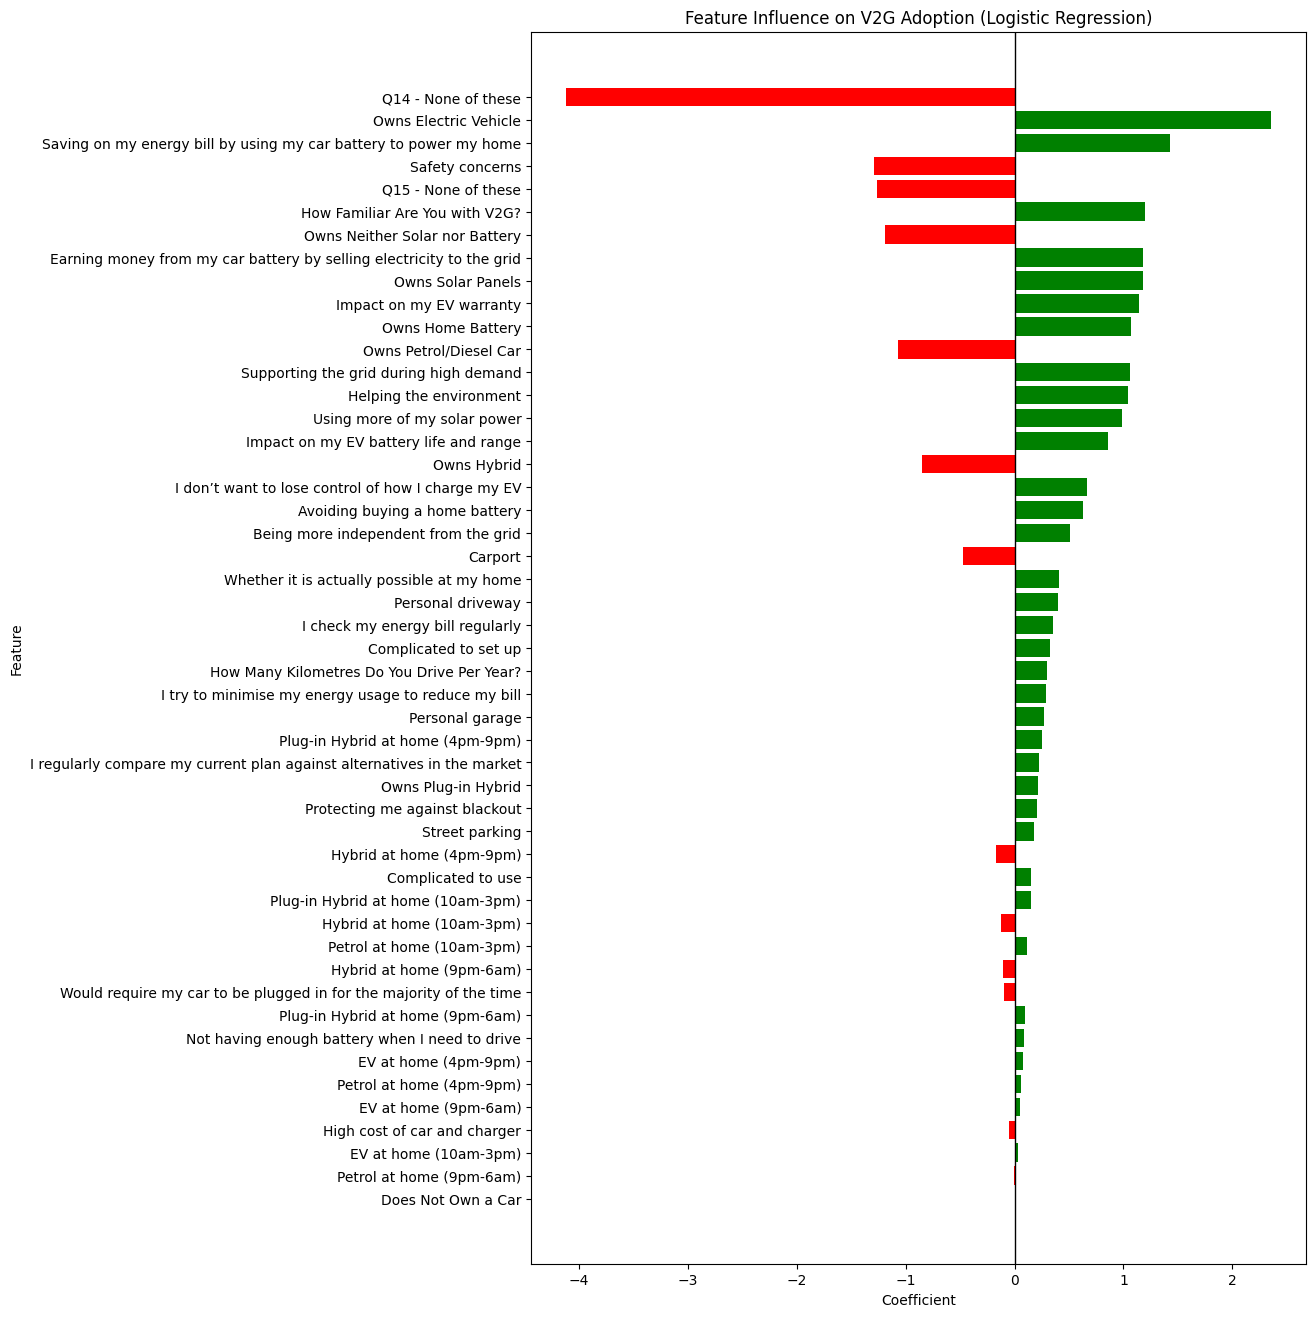

In [24]:
import matplotlib.pyplot as plt

# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Plot
plt.figure(figsize=(10, 16))
plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=["green" if x > 0 else "red" for x in results_df_sorted["Coefficient"]])
plt.axvline(0, color="black", linewidth=1)  # Add a vertical line at 0 for reference
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)")
plt.show()


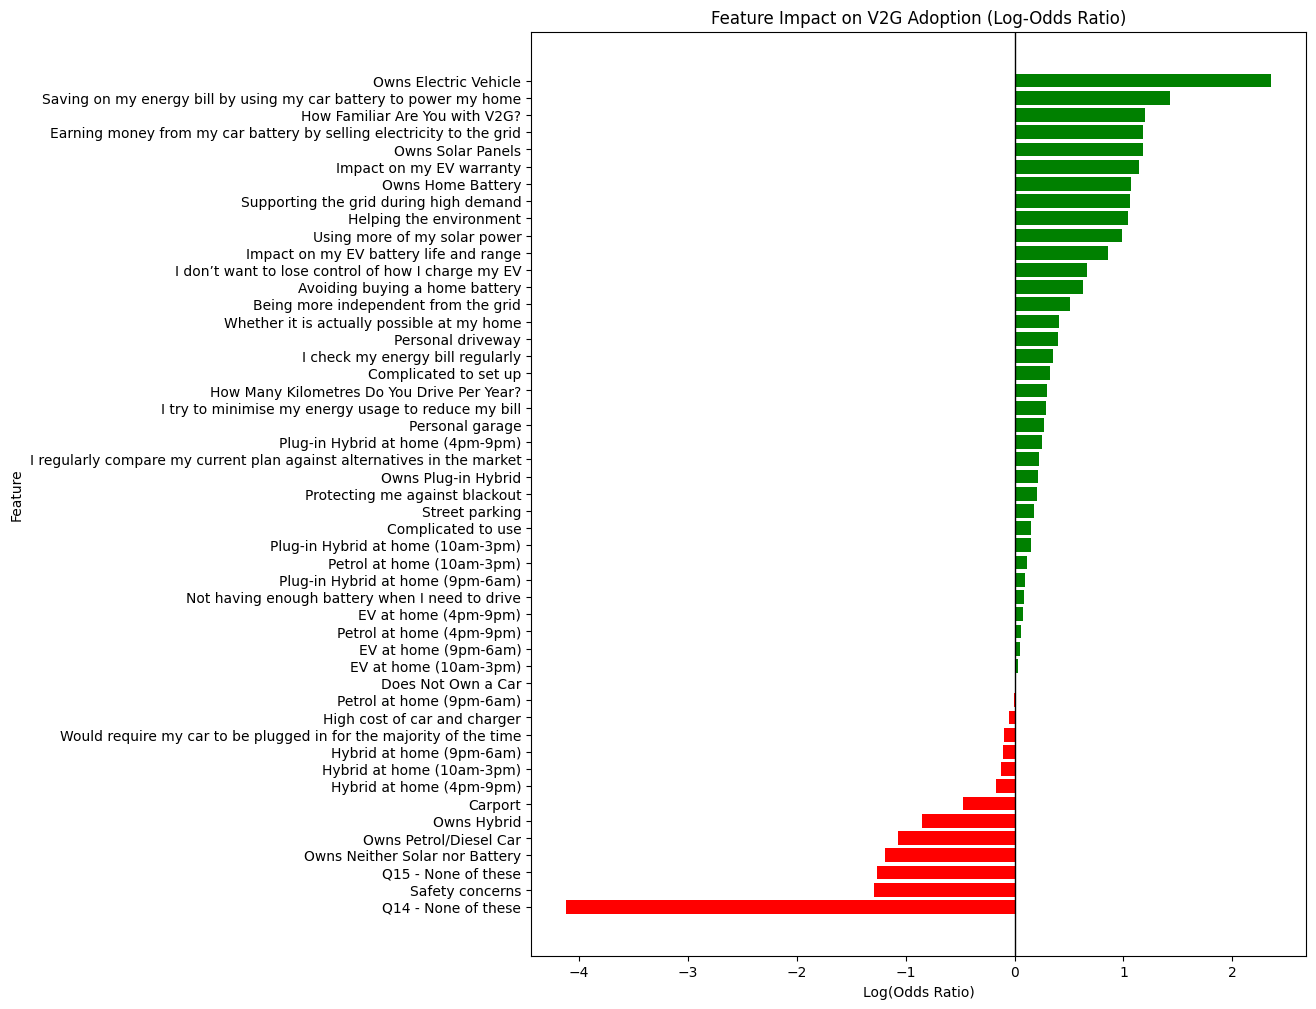

In [25]:
# Sort by odds ratio
results_df_sorted = results_df.sort_values(by="Odds Ratio", ascending=True)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], np.log(results_df_sorted["Odds Ratio"]),color=["green" if x > 0 else "red" for x in results_df_sorted["Coefficient"]])
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Log(Odds Ratio)")
plt.ylabel("Feature")
plt.title("Feature Impact on V2G Adoption (Log-Odds Ratio)")
plt.show()


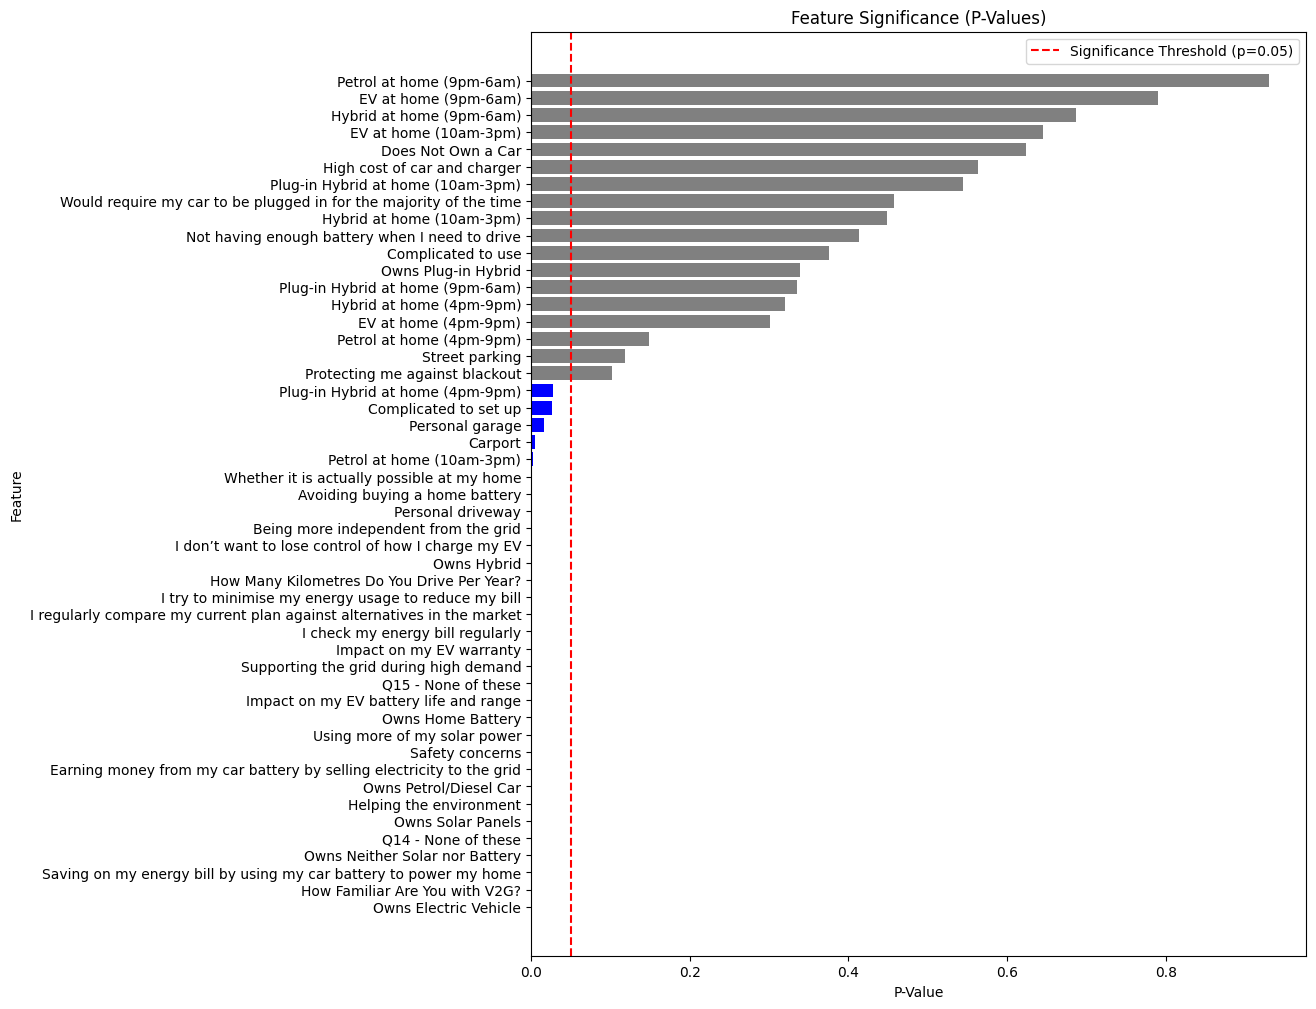

In [26]:
import matplotlib.pyplot as plt

# Sort by p-value
results_df_sorted = results_df.sort_values(by="P-value", ascending=True)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], results_df_sorted["P-value"], color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(0.05, color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (p=0.05)")
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (P-Values)")
plt.legend()
plt.show()


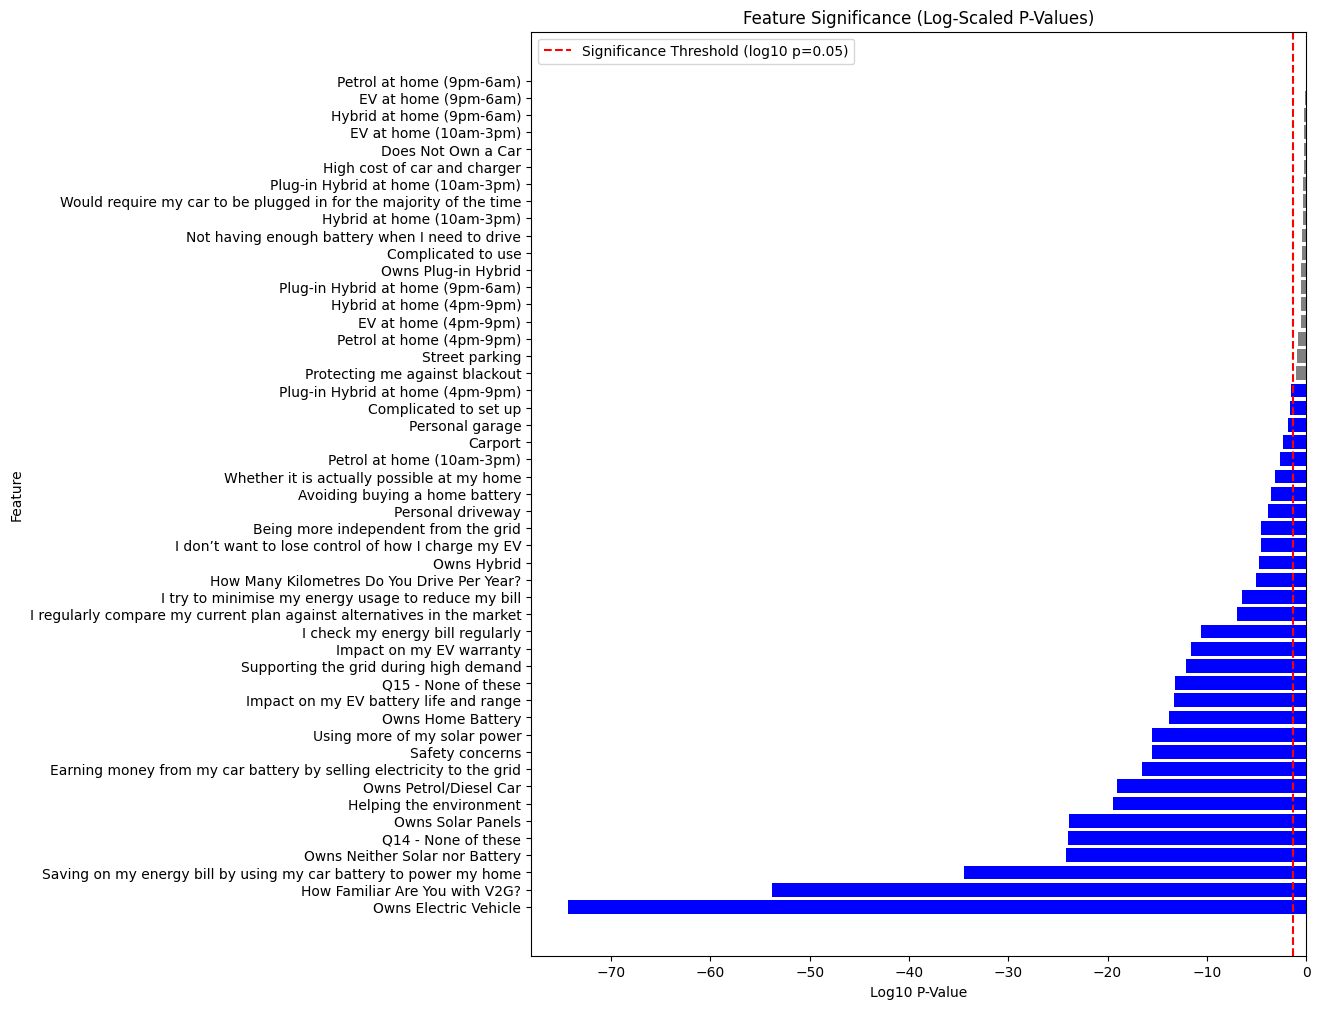

In [27]:
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], np.log10(results_df_sorted["P-value"]), color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(np.log10(0.05), color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (log10 p=0.05)")
plt.xlabel("Log10 P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (Log-Scaled P-Values)")
plt.legend()
plt.show()

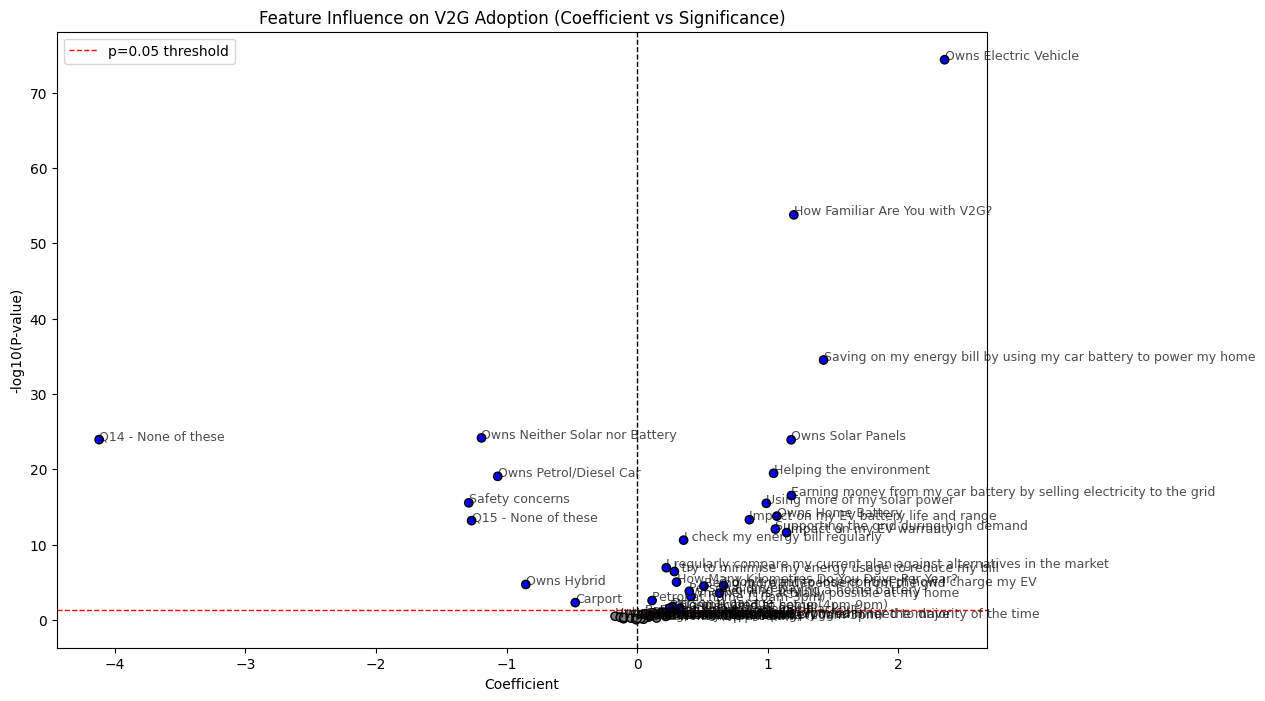

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Compute -log(p-value) for better visualization
results_df["-log(p)"] = -np.log10(results_df["P-value"])

# Define colors based on significance threshold (p < 0.05)
colors = ["blue" if p < 0.05 else "gray" for p in results_df["P-value"]]

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df["Coefficient"], results_df["-log(p)"], c=colors, edgecolors="black")

# Add labels for key points
for i, txt in enumerate(results_df["Feature"]):
    plt.annotate(txt, (results_df["Coefficient"].iloc[i], results_df["-log(p)"].iloc[i]), fontsize=9, alpha=0.7)

# Reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Vertical line at zero coefficient
plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1, label="p=0.05 threshold")  # Horizontal line at p=0.05

# Labels & title
plt.xlabel("Coefficient")
plt.ylabel("-log10(P-value)")
plt.title("Feature Influence on V2G Adoption (Coefficient vs Significance)")
plt.legend()
plt.show()


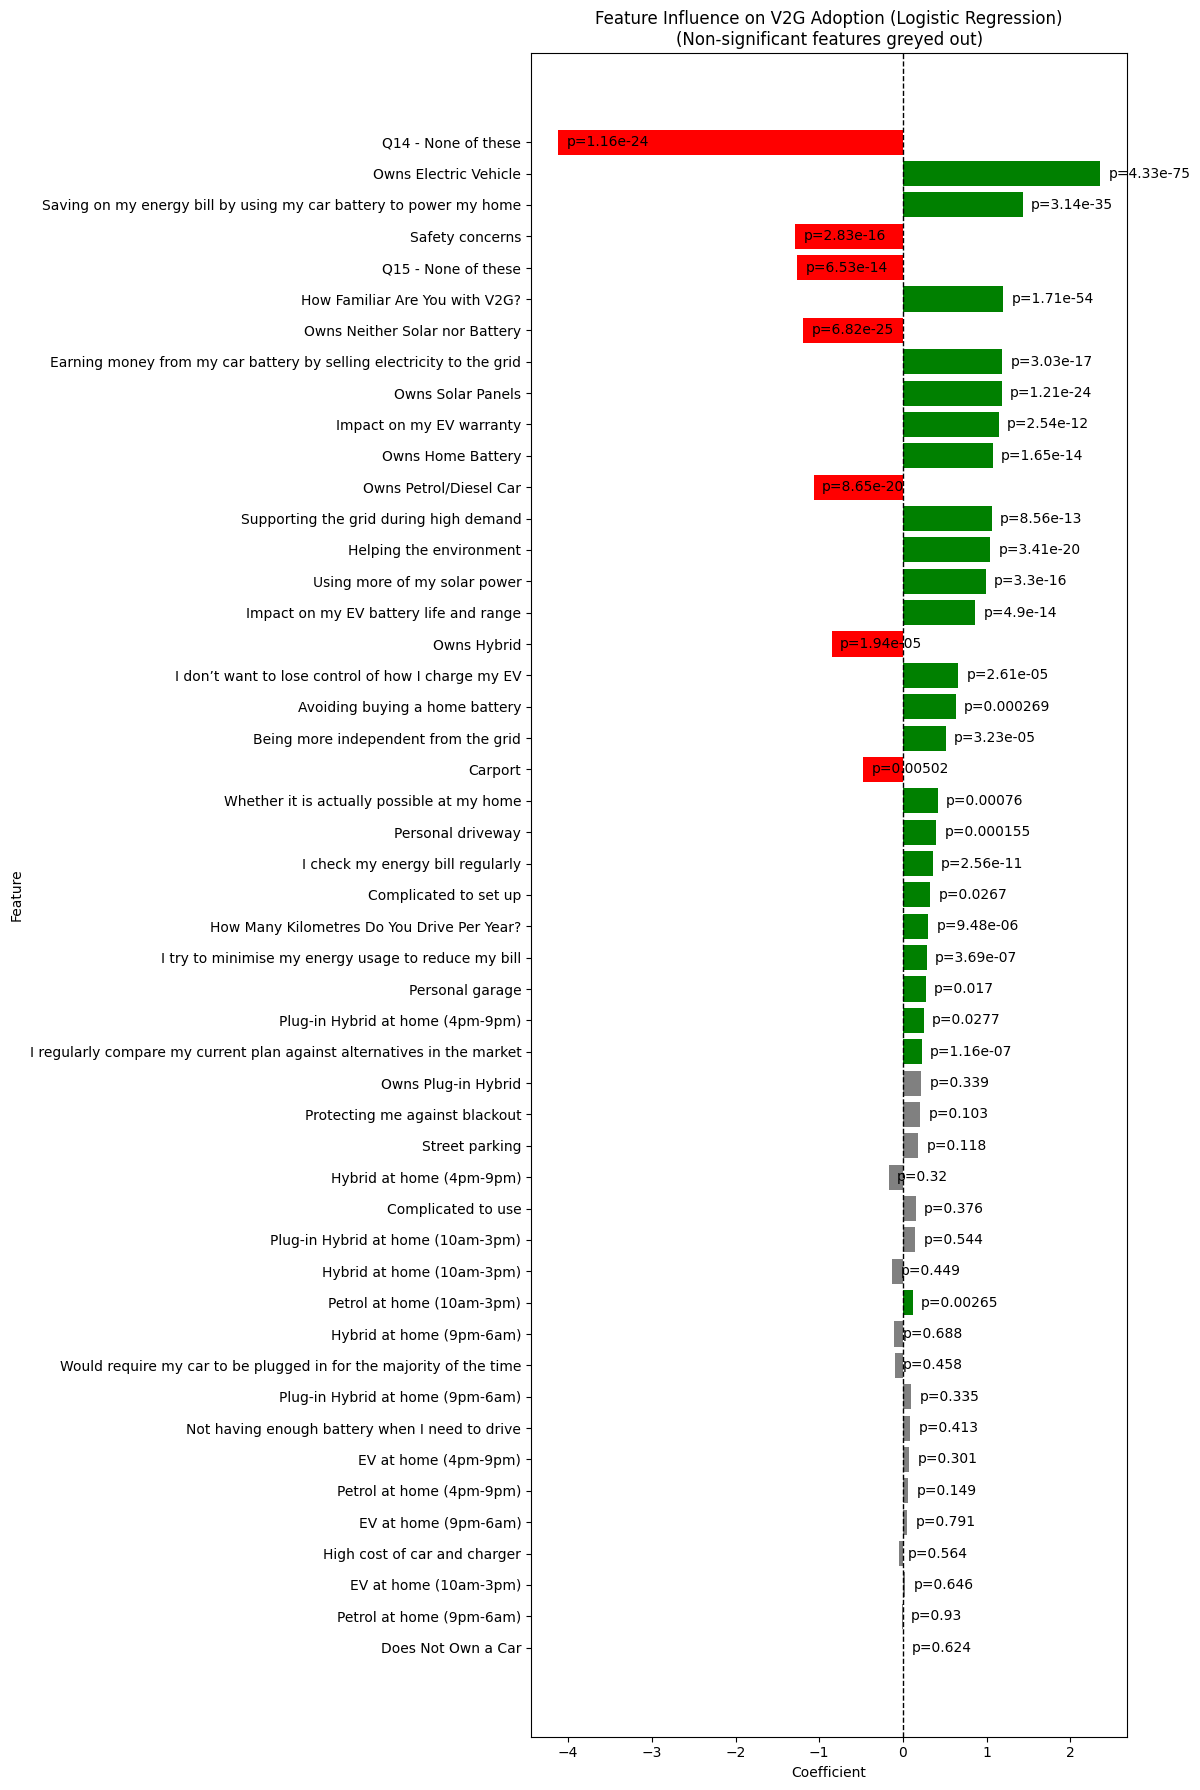

In [29]:
import matplotlib.pyplot as plt

# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Define colors: Gray for p >= 0.05, Green for positive, Red for negative
colors = [
    "gray" if p >= 0.05 else ("green" if coef > 0 else "red")
    for p, coef in zip(results_df_sorted["P-value"], results_df_sorted["Coefficient"])
]

# Create figure
plt.figure(figsize=(12, 18))
bars = plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=colors)

# Add p-value annotations on the right side
for bar, p_value in zip(bars, results_df_sorted["P-value"]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"p={p_value:.3g}", va='center', fontsize=10)

# Reference line at zero
plt.axvline(0, color="black", linewidth=1, linestyle="--")

# Labels and title
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)\n(Non-significant features greyed out)")
plt.tight_layout()  # Adjust layout to prevent text cutoff

# Show the plot
plt.show()


# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [30]:
# Get the list of significant features (p < 0.05)
significant_features = results_df[results_df["P-value"] < 0.05]["Feature"].tolist()

# Map back to original column names using feature_label_map
significant_columns = [key for key, value in feature_label_map.items() if value in significant_features]

# Ensure the target variable is retained
significant_columns.append(target_variable)

# Create a new filtered list for columns_of_interest
columns_of_interest_filtered = [
    col for col in columns_of_interest if col in significant_columns
]

# Display before and after
print(f"Original columns count: {len(columns_of_interest)}")
print(f"Filtered columns count: {len(columns_of_interest_filtered)}")

Original columns count: 59
Filtered columns count: 32


In [31]:
filtered_df = df[columns_of_interest_filtered]

In [32]:
filtered_df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax3_2,Q1_1,Q1_2,Q1_4,...,Q15_3,Q15_5,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3.0,0.0,1,0,0,...,0,1,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
1,Very familiar,"Less than 10,000",1,1,0,5.0,0.0,1,1,0,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1
2,Not at all familiar,"20,001-50,000",0,0,1,2.0,0.0,1,0,0,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
3,Not at all familiar,"Less than 10,000",0,0,1,0.0,0.0,0,0,1,...,0,1,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0
4,Very familiar,"20,001-50,000",1,1,0,5.0,0.0,1,1,1,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,0.0,0.0,0,1,0,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1354,Somewhat familiar,"Less than 10,000",0,0,1,5.0,0.0,1,0,0,...,0,0,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0
1355,Very familiar,"10,000-20,000",1,0,0,4.0,0.0,1,1,0,...,0,1,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,"10,000-20,000",0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


## 4.2. 

# 4. Binomial Logistic Regression

In [33]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_32372\3615609723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
C:\Users\24417507\AppData\Local\Temp\ipykernel_32372\3615609723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)


In [34]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9         0
Q2         0
Q8_1       0
Q8_2       0
Q8_99      0
Q6ax1_1    0
Q6ax3_2    0
Q1_1       0
Q1_2       0
Q1_4       0
Q3_1       0
Q3_2       0
Q3_3       0
Q14_1      0
Q14_2      0
Q14_3      0
Q14_4      0
Q14_5      0
Q14_6      0
Q14_8      0
Q14_99     0
Q15_2      0
Q15_3      0
Q15_5      0
Q15_7      0
Q15_8      0
Q15_10     0
Q15_99     0
Q7_1       0
Q7_2       0
Q7_3       0
Q10_2      0
dtype: int64

Checking unique values in target variable (Q10_2):
[0 1]

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


In [35]:
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

In [36]:
filtered_df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax3_2,Q1_1,Q1_2,Q1_4,...,Q15_3,Q15_5,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3.0,0.0,1,0,0,...,0,1,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
1,Very familiar,"Less than 10,000",1,1,0,5.0,0.0,1,1,0,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1
2,Not at all familiar,"20,001-50,000",0,0,1,2.0,0.0,1,0,0,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
3,Not at all familiar,"Less than 10,000",0,0,1,0.0,0.0,0,0,1,...,0,1,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0
4,Very familiar,"20,001-50,000",1,1,0,5.0,0.0,1,1,1,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,0.0,0.0,0,1,0,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1354,Somewhat familiar,"Less than 10,000",0,0,1,5.0,0.0,1,0,0,...,0,0,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0
1355,Very familiar,"10,000-20,000",1,0,0,4.0,0.0,1,1,0,...,0,1,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,"10,000-20,000",0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


In [37]:
filtered_df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax3_2,Q1_1,Q1_2,Q1_4,...,Q15_3,Q15_5,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3.0,0.0,1,0,0,...,0,1,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
1,Very familiar,"Less than 10,000",1,1,0,5.0,0.0,1,1,0,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1
2,Not at all familiar,"20,001-50,000",0,0,1,2.0,0.0,1,0,0,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
3,Not at all familiar,"Less than 10,000",0,0,1,0.0,0.0,0,0,1,...,0,1,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0
4,Very familiar,"20,001-50,000",1,1,0,5.0,0.0,1,1,1,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,0.0,0.0,0,1,0,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1354,Somewhat familiar,"Less than 10,000",0,0,1,5.0,0.0,1,0,0,...,0,0,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0
1355,Very familiar,"10,000-20,000",1,0,0,4.0,0.0,1,1,0,...,0,1,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,"10,000-20,000",0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


In [38]:
print("Before filtering:")
print(df[target_variable].value_counts())

Before filtering:
1    711
0    647
Name: Q10_2, dtype: int64


In [39]:
print("After filtering:")
print(filtered_df[target_variable].value_counts())

After filtering:
1    711
0    647
Name: Q10_2, dtype: int64


In [40]:
# Train model with binary logistic regression
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([507, 577], dtype=int64))
Unique values in y_test: (array([0, 1]), array([139, 132], dtype=int64))
Train Accuracy: 81.83%
Test Accuracy: 79.34%


# 4. Plotting

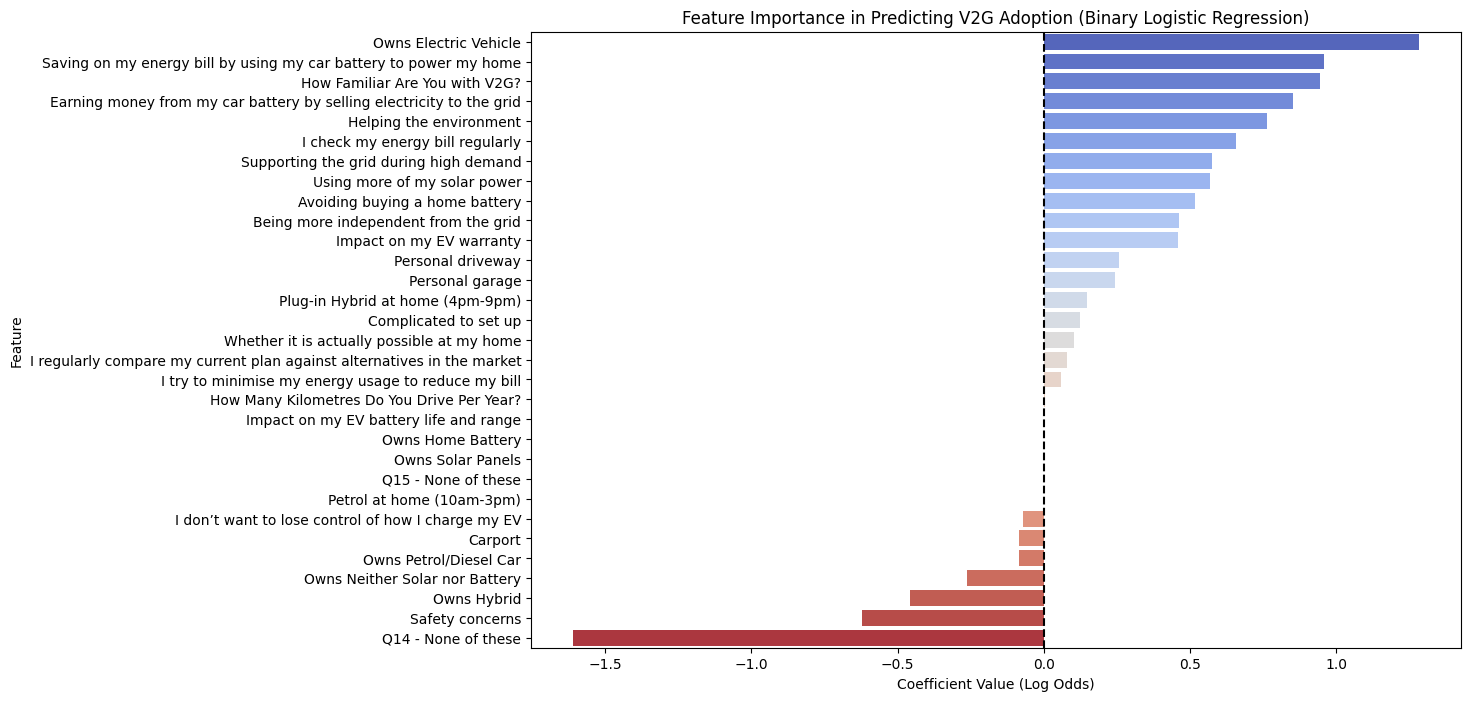

In [43]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

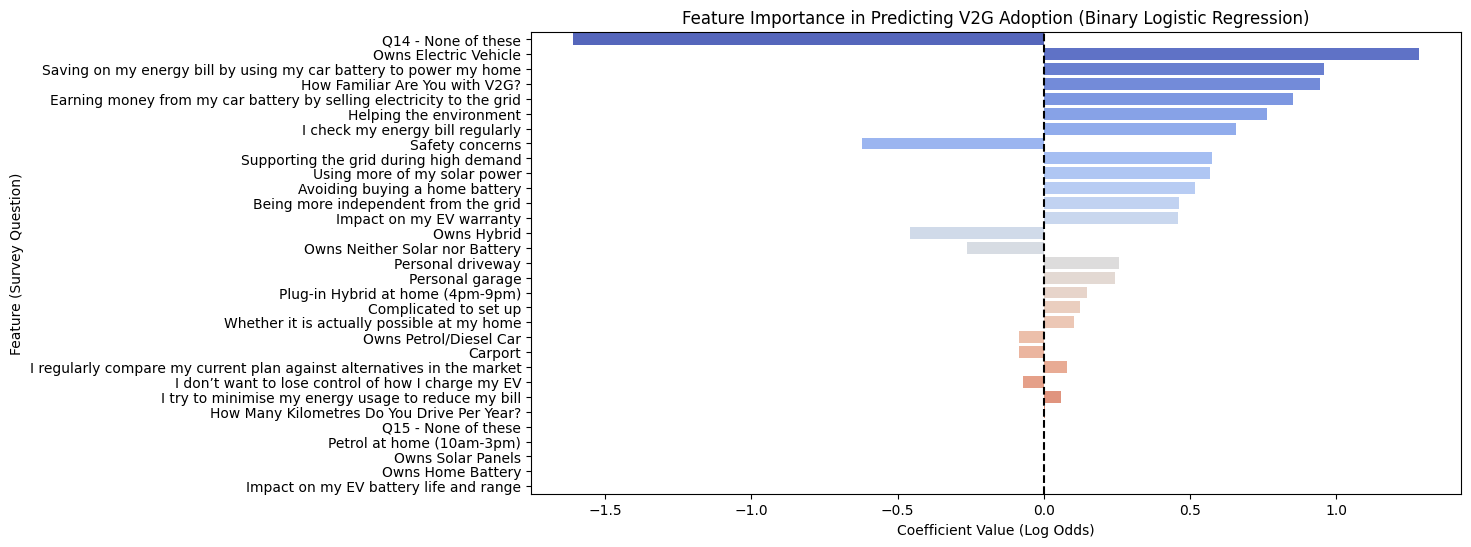

In [44]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature (Survey Question)")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [45]:
from sklearn.metrics import accuracy_score

# Predict on test data
y_pred_binary = model_binary.predict(X_test)

# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

Model Accuracy: 79.34%


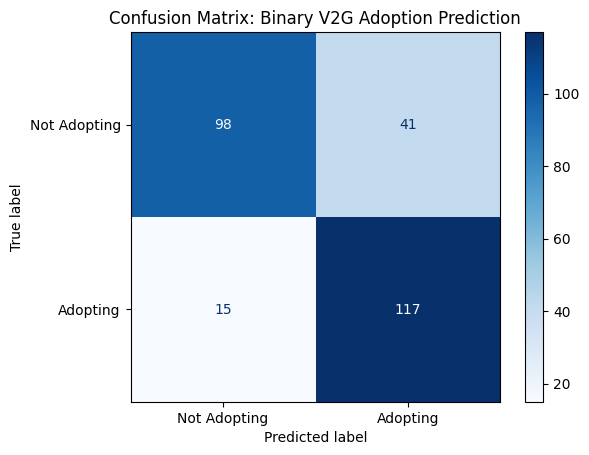

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_binary = confusion_matrix(y_test, y_pred_binary, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["Not Adopting", "Adopting"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Binary V2G Adoption Prediction")
plt.show()

In [ ]:
df.loc[df["Q1_2"] == 0, q6a_ev] = 0  # Set EV charging times to 0 if they don't own an EV
df.loc[df["Q1_1"] == 0, q6a_petrol] = 0  # Set Petrol charging times to 0 if they don't own a Petrol car

In [ ]:
valid_rows = df[input_variables_extended + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")

In [ ]:
# Train model with binary logistic regression
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    df,  
    input_variables_extended,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

In [ ]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': input_variables_extended, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [ ]:
coefs_binary_df

# 5. Regression per segmentation

In [ ]:
q1_columns = ["Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_99"]  # Add all binary ownership columns
df[q1_columns] = df[q1_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [ ]:
# Define segments based on ownership
ev_owners = df[df["Q1_2"] == 1]  # People who own EVs
petrol_owners = df[df["Q1_1"] == 1]  # People who own Petrol/Diesel
# hybrid_owners = df[df["Q1_4"] == 1]  # People who own Hybrids
# phev_owners = df[df["Q1_3"] == 1]  # People who own Plug-in Hybrids

In [ ]:
# Multi-vehicle owners (People who own 2 or more types)
ev_petrol_owners = df[(df[["Q1_1", "Q1_2"]].sum(axis=1) > 1)]

# Define input variables per group
input_variables_ev = input_variables + q6a_ev
input_variables_petrol = input_variables + q6a_petrol
# input_variables_hybrid = input_variables + q6a_hybrid
# input_variables_phev = input_variables + q6a_plughyb
input_variables_multi = input_variables + q6a_ev + q6a_petrol


## 5.1. For EV owners

In [ ]:
print("Checking if any feature column is missing data...")
print(ev_owners[input_variables_extended].isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(ev_owners[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = ev_owners[input_variables_extended + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {ev_owners.shape[0]}")


In [ ]:
# Run logistic regression for each segment
def run_segmented_logistic_regression(df_segment, input_vars, vehicle_type):
    print(f"Running Logistic Regression for {vehicle_type} Owners")
    
    # Train model
    model, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
        df_segment,
        input_vars,
        target_variable,
        TRANSFORMERS_q6a,
        do_normalize=True,
        test_split_ratio=0.2
    )
    
    # Extract Coefficients
    coefs_binary = model.coef_[0]  
    coefs_binary_df = pd.DataFrame({'Feature': input_vars, 'Coefficient': coefs_binary})
    coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
    coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)
    
    print("\n🔍 Top Predictors for V2G Adoption in", vehicle_type, "Owners:")
    display(coefs_binary_df)  # Show top predictors for this group

In [ ]:
run_segmented_logistic_regression(ev_owners, input_variables_ev, "EV")
run_segmented_logistic_regression(petrol_owners, input_variables_petrol, "Petrol")
run_segmented_logistic_regression(ev_petrol_owners, input_variables_multi, "Multi-Vehicle")

# 6. p-values

In [ ]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

# List to store results
results = []

# Loop over each input variable individually
for feature in input_variables_extended:
    print(f"Running Logistic Regression for: {feature}")

    # Ensure the feature exists in the dataframe
    if feature not in df.columns:
        print(f"Skipping {feature} (not in dataframe)")
        continue

    # Convert feature using the transformer if available, otherwise cast to numeric
    if feature in TRANSFORMERS_q6a:
        X_single = df[feature].apply(TRANSFORMERS_q6a[feature])
    else:
        X_single = pd.to_numeric(df[feature], errors="coerce")  # Convert safely

    # Drop NaN values
    valid_rows = ~X_single.isna()
    X_single = X_single[valid_rows].values.reshape(-1, 1)
    y = df.loc[valid_rows, target_variable].values  # Ensure target aligns with valid rows
    

    # Check if feature has only one unique value
    if len(np.unique(X_single)) == 1:
        print(f"Skipping {feature} (constant value: {np.unique(X_single)[0]})")
        continue

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficient & odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)

    # Fit logistic regression using statsmodels for p-value
    X_with_intercept = sm.add_constant(X_single)
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress verbose output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Sort by strongest effect (absolute coefficient)
results_df["abs_coef"] = results_df["Coefficient"].abs()
results_df = results_df.sort_values(by="abs_coef", ascending=False)


In [ ]:
results_df

In [ ]:
# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary).astype(int)

# List to store results
results = []

# Use all features
all_features = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + input_variables_vehicle_ownership +
    parking + energ_literacy +
    intent_to_purchase_vehicle + benefits_v2g + concerns_v2g +
    interest_in_services + consider_using_NRMA_for +
    charging_control + preference_on_batt_use + expected_return
)

In [ ]:
df['Q9']

In [ ]:
# Loop over each input variable individually
for feature in columns_of_interest_filtered:
    print(f"Running Logistic Regression for: {feature}")

    # Ensure the feature exists in the dataframe
    if feature not in df.columns:
        print(f"Skipping {feature} (not in dataframe)")
        continue

    # Convert feature using the transformer if available, otherwise cast to numeric
    if feature in TRANSFORMERS_q6a:
        X_single = df[feature].apply(TRANSFORMERS_q6a[feature])
    else:
        X_single = pd.to_numeric(df[feature], errors="coerce")  # Convert safely

    # Drop NaN values
    valid_rows = ~X_single.isna()
    X_single = X_single[valid_rows].values.reshape(-1, 1)
    y = df.loc[valid_rows, target_variable].values  # Ensure target aligns with valid rows

    # Check if feature has only one unique value
    if len(np.unique(X_single)) == 1:
        print(f"Skipping {feature} (constant value: {np.unique(X_single)[0]})")
        continue

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficient & odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)

    # Fit logistic regression using statsmodels for p-value
    X_with_intercept = sm.add_constant(X_single)
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress verbose output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Sort by strongest effect (absolute coefficient)
results_df["abs_coef"] = results_df["Coefficient"].abs()
results_df = results_df.sort_values(by="abs_coef", ascending=False)